<h1>
<center>Finding Regimes in Time Series</center>
</h1>

<h1>
<center>Avery Lee</center>
</h1>

<p align="center">
  <img src="images/intro.png" alt="Intro image" width="700"/>
</p>

# Finding Regimes in Time Series Data for Inflation and Unemployment Rates 

In this project we will use KMeans Clustering to find regimes in time series data for US inflation and unemployment rates. 

- Datasets: from FRED 
    - US Unemployment Rate (monthly)
    - Consumer Price Index for all Urban Consumers, Seasonally Adjusted (monthly) -> YoY Inflation Rate 
        - Seasonal adjustment smooths out holiday or seasonal swings so we can see the underlying swings in prices 

- Data Preprocessing 
    - Train (~70%), Test (~30%) 
    - Standard Scaler 

- Determine Number of Regimes 
    - Inertia 
    - Silhouette scores 
    - Silhouette diagram 
    - k=3 was chosen as the overall best number of clusters 

- Visualize the Clusters on 2D plot 
    - Done for each k 

- Time Series Cluster Plot

- Regime Predictions 

In [1]:
# Standard Library
import warnings
from datetime import datetime

# Data Handling
import numpy as np
import pandas as pd
import pandas_datareader as pdr

# Visualization
import matplotlib.pyplot as plt
from yellowbrick.cluster import SilhouetteVisualizer

# Math 
from scipy.spatial import distance

# Machine Learning
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore")

## Datasets 

Obtain the unemployment rate and CPI from FRED. We can then convert the CPI to the yearly inflation rate. 

Inflation rate (year-over-year) = $\frac{CPI_{t} - CPI_{t-12}}{CPI_{t-12}}$ = $\frac{CPI_{t}}{CPI_{t-12}} - \frac{CPI_{t-12}}{CPI_{t-12}}$ = $\frac{CPI_{t}}{CPI_{t-12}} - 1$

In [2]:
start = datetime(1945,1,1)
end = datetime(2025,7,1)

unemp_data = pdr.get_data_fred('UNRATE', start, end) # US monthly unemployment rate 
cpi_data = pdr.get_data_fred('CPIAUCSL', start, end) # monthly Consumer Price Index for all urban consumers, seasonally adjusted 
inf_data = (cpi_data/cpi_data.shift(12)-1).iloc[12:]
inf_data = inf_data.rename(columns={'CPIAUCSL': 'Inflation'})
data = pd.concat([inf_data, unemp_data],axis=1)
data

,Inflation,UNRATE
DATE,,
1948-01-01,0.102421,3.4
1948-02-01,0.094820,3.8
1948-03-01,0.068182,4.0
1948-04-01,0.082727,3.9
1948-05-01,0.093850,3.5
...,...,...
2025-03-01,0.024056,4.2
2025-04-01,0.023337,4.2
2025-05-01,0.023759,4.2


## Data Preprocessing 

We will split the data into a training set (before Jan 2005, ~70%) and a test set (Jan 2005 and after, ~30%). 

In [3]:
split_date = '2005-1-1'
training = data[:split_date]
testing = data[split_date:]

print(training.shape, testing.shape)

(685, 2) (247, 2)


Since the data isn't normalized to the same scale yet, use a Standard Scaler to normalize the data. This will set the mean to 0 and std to 1. Clustering algorithms like KMeans work well with normalized data. 

In [4]:
# Standard Scaler 
scaler = StandardScaler()
train = scaler.fit_transform(training)
test = scaler.transform(testing)

## Determine Number of Regimes 

To cluster the time series into different regimes, we will ignore the time series portion of the data and treat this as a 2 dimensional dataset. Each cluster is considered a regime. 

Let's try testing out 9 different number of clusters, k, from 2 to 10. To choose the best k, we can plot the inertia, silhouette scores, and silhouette diagram. 

- Inertia: 
    - There is not a super clear "elbow" from the inertia plot, but the decrease is less around k=3 or 4. 

$$\text{Inertia} = \sum_{i=1}^{n} \|x_i - \mu_{c_i}\|^2$$

$$x_i = \text{datapoint}$$

$$\mu_{c_i} = \text{centroid}$$

- Silhouette scores: 
    - A k with a higher silhouette score means better clustering quality. It seems k = 2, 3, and 9 are all possible options. 

$$\text{Silhouette Score(i)} = \frac{b(i) - a(i)}{\max(a(i), b(i))}$$

$$a(i) = \text{average distance to other points in the same cluster}$$

$$b(i) = \text{average distance to other points in the nearest other cluster}$$

- Silhouette diagram 
    - Clusters in k=3 all have similar coefficients and the coefficients are relatively high. They rarely drop below 0. 


**We will proceed with k=3 based on the results from studying inertia, silhouette scores, and silhouette diagram.**

In [5]:
# k's
ks = range(2,10+1) 
kmc_per_k = {k:KMeans(n_clusters=k, n_init=10, random_state=42).fit(train) for k in ks} # default n_init=auto may work worse for smaller datasets, so set n_init=10 
inertias = [model.inertia_ for model in kmc_per_k.values()]
silhouette_scores = [silhouette_score(train, model.labels_) for model in kmc_per_k.values()]

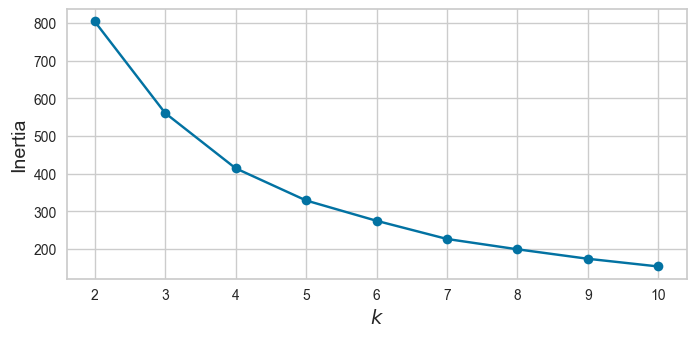

In [6]:
plt.figure(figsize=(8, 3.5))
plt.plot(ks, inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.show()

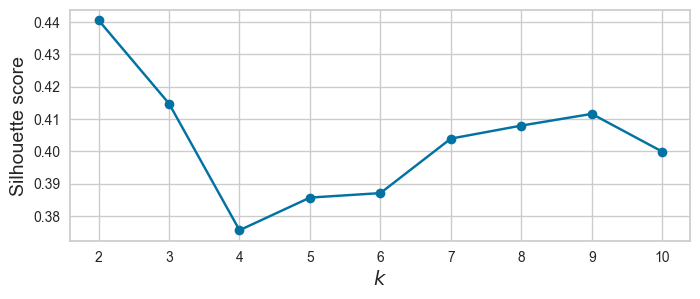

In [7]:
plt.figure(figsize=(8, 3))
plt.plot(ks, silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.show()

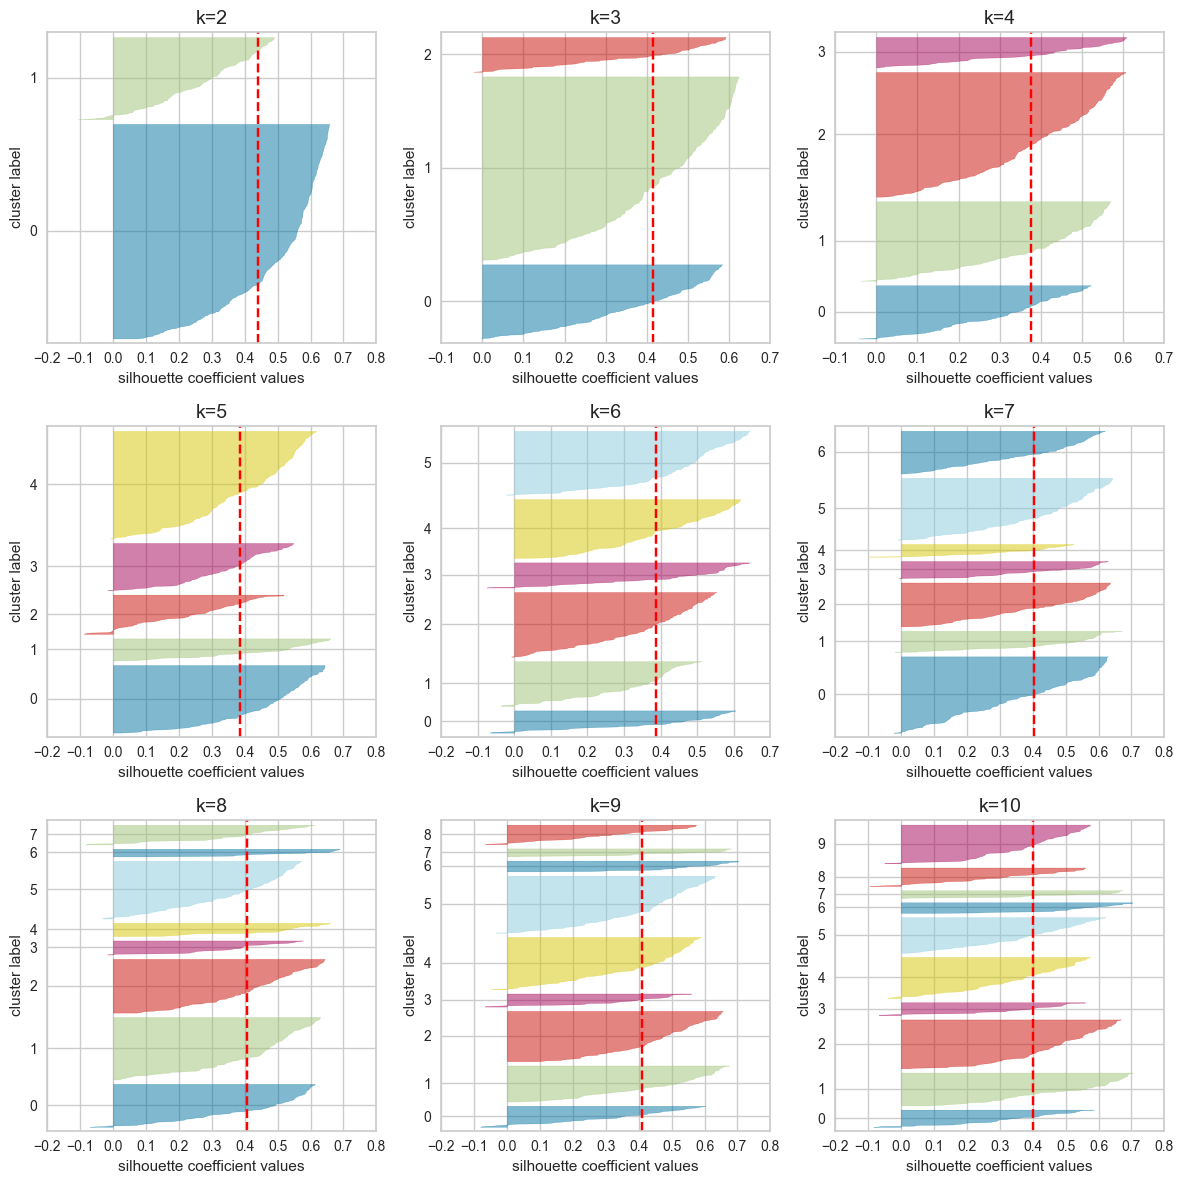

In [8]:
plt.figure(figsize=(12, 12))

for idx, k in enumerate(ks):
    ax = plt.subplot(3, 3, idx + 1)
    model = KMeans(n_clusters=k, n_init=10, random_state=42)
    visualizer = SilhouetteVisualizer(model, colors='yellowbrick', ax=ax)
    visualizer.fit(train) # fits model and computes silhouette scores
    # remove the red average silhouette score legend as it creates clutter 
    for line in ax.lines:
        line.set_label('_nolegend_') 
    visualizer.finalize() 
    plt.title(f"k={k}", fontsize=14)

plt.tight_layout()
plt.show()

## Visualize KMeans Clustering 

We can visualize what the clustering looks like in a 2D scatterplot for each k, using distance from centroids to determine which cluster. 

In [9]:
centroids_list = [kmc.cluster_centers_ for kmc in kmc_per_k.values()]
centroids_list

[array([[-0.36733388, -0.42687218],
        [ 0.95700143,  1.11211437]]),
 array([[ 0.0389177 ,  1.14423297],
        [-0.42597618, -0.52331482],
        [ 2.14600121,  0.30982341]]),
 array([[ 0.33646297,  1.40403042],
        [-0.24388355, -1.12181203],
        [-0.5315782 ,  0.0647528 ],
        [ 2.20151152,  0.19922989]]),
 array([[-0.50234526, -1.09968501],
        [ 2.42261353,  0.85988142],
        [ 0.89228058, -0.60054362],
        [ 0.20205245,  1.43117608],
        [-0.60517177,  0.10313757]]),
 array([[ 0.94320713, -1.21687104],
        [ 0.19443131,  1.46143554],
        [-0.89502314,  0.16903119],
        [ 2.32927293,  0.74169119],
        [ 0.0450852 ,  0.00603192],
        [-0.5365223 , -1.07197039]]),
 array([[-0.79283414, -0.00773773],
        [ 2.4425424 ,  0.63797827],
        [-0.07715639,  1.04891973],
        [ 1.13621528, -1.22238359],
        [ 0.72398588,  2.43751063],
        [-0.47457464, -1.13321009],
        [ 0.27722705,  0.01189274]]),
 array([[ 0.0447

In [10]:
# Centroids for k=3
centroids_list[1]

array([[ 0.0389177 ,  1.14423297],
       [-0.42597618, -0.52331482],
       [ 2.14600121,  0.30982341]])

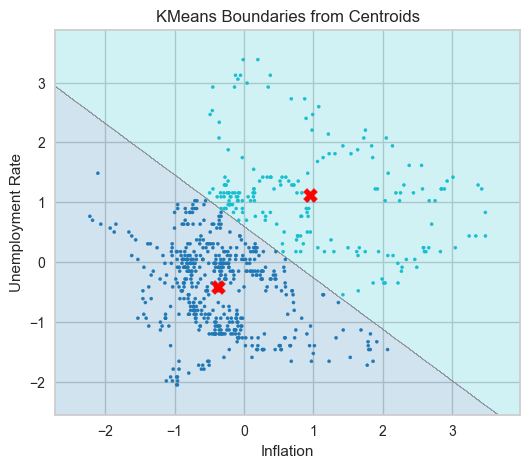

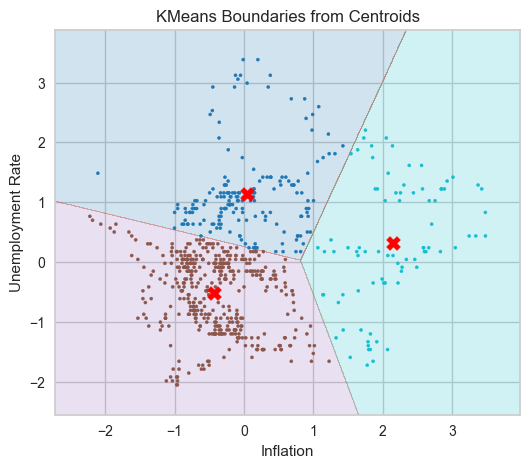

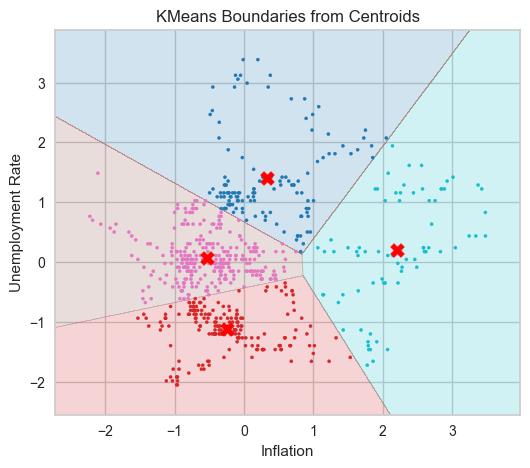

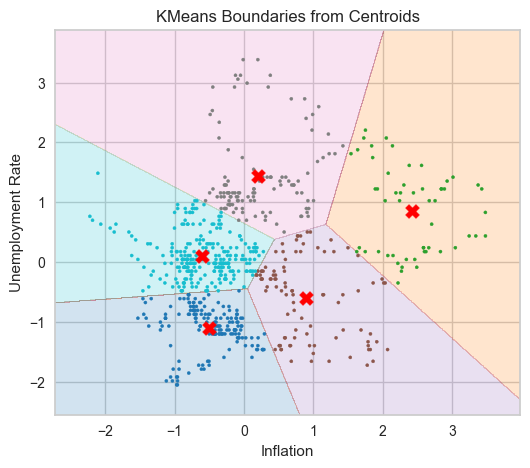

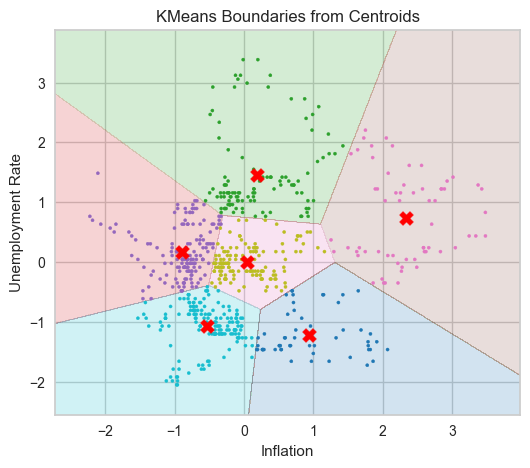

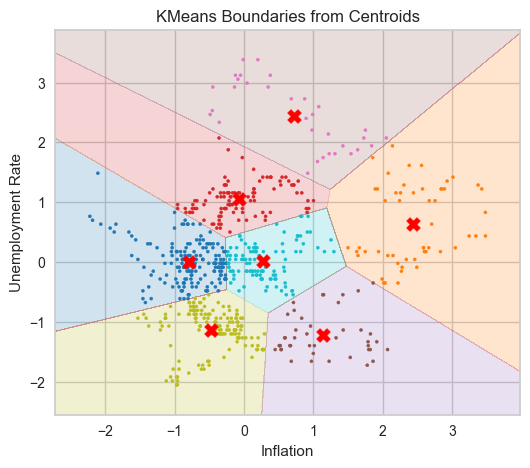

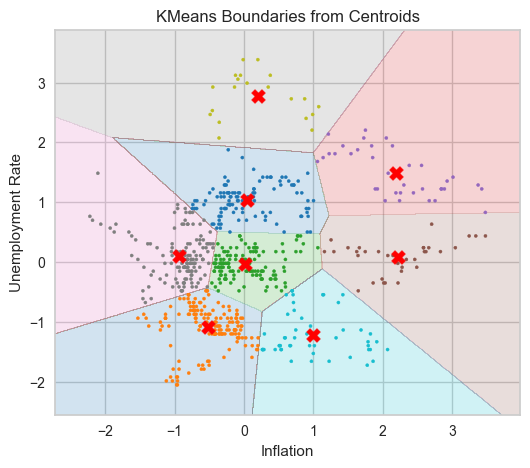

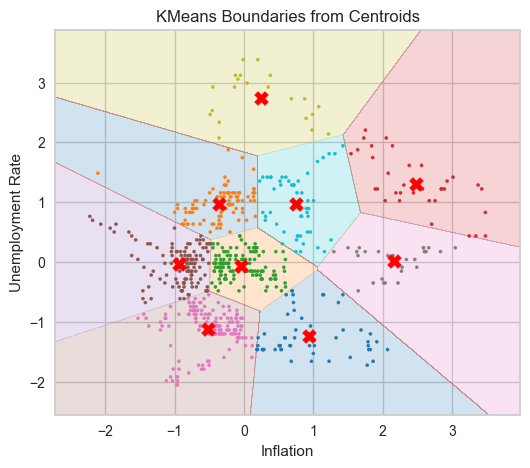

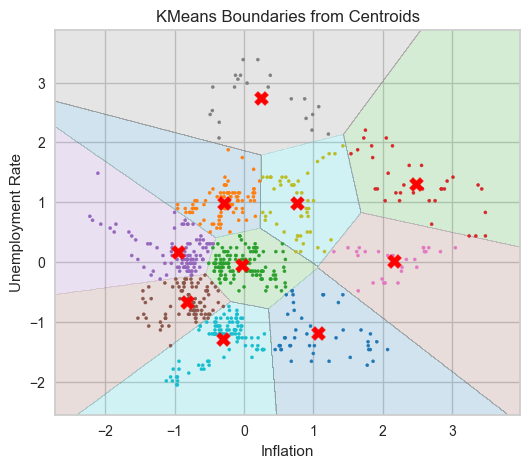

In [11]:
def plot_clusters(X, kmc_per_k):
    for k, kmc in kmc_per_k.items():
        centroids = kmc.cluster_centers_

        plt.figure(figsize=(6, 5))

        # create mesh grid
        padding = 0.5 # so the points don't touch the edge of the plot 
        # inflation col 
        x_min = X[:, 0].min() - padding 
        x_max = X[:, 0].max() + padding
        # unemployment col 
        y_min = X[:, 1].min() - padding 
        y_max = X[:, 1].max() + padding 

        # x and y coordinates on the plot 
        resolution = 1000 # number of points on grid for each x and y 
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, resolution), np.linspace(y_min, y_max, resolution)) # shape: (resolution, resolution)
        grid = np.c_[xx.ravel(), yy.ravel()] # get all the (x,y) coordinate pairs, shape: (resolution^2, 2)

        # assign each grid point to the nearest centroid for section coloring 
        grid_to_centroids = distance.cdist(grid, centroids) # shape: (resolution^2, k)
        Z = np.argmin(grid_to_centroids, axis=1) # get the index of the minimum in each row, shape: (resolution^2, 1)
        Z = Z.reshape(xx.shape) # shape: (resolution, resolution)

        # assign each X point to the nearest centroid for datapoint coloring by section 
        X_to_centroids = distance.cdist(X, centroids) # shape: (X rows, k)
        labels = np.argmin(X_to_centroids, axis=1) # shape: (X rows, 1)

        # Plot boundaries
        plt.contourf(xx, yy, Z, alpha=0.2, cmap=plt.cm.tab10)
        plt.scatter(X[:, 0], X[:, 1], s=5, c=labels, cmap=plt.cm.tab10) # plot the datapoints 
        plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=100, marker='X') # plot the centroids 
        plt.title('KMeans Boundaries from Centroids')
        plt.xlabel('Inflation')
        plt.ylabel('Unemployment Rate')
        plt.show()

    
plot_clusters(train, kmc_per_k)


## Time Series Cluster Plot 

Now, let's plot the time series clusters in orange using k=3 as we defined earlier. We will use the scaled data to fit the model as done before, but unscale it using `inverse_transform` to visualize the raw inflation and unemployment rates clusters. 

As we see in the plots, the orange creates 3 clusters (represented by 3 unique y values) over the time period. It generally captures the regimes well for both inflation and unemployment rate. 

In [12]:
best_k = 3
kmc_scaled = KMeans(n_clusters=best_k, n_init=10, random_state=42).fit(train)

centroids_scaled_train = kmc_scaled.cluster_centers_ # (k, 2)
scaled_pred_train = kmc_scaled.labels_ # also the index of its centroid in centroids_unscaled_train, (training rows, 1)

centroids = scaler.inverse_transform(centroids_scaled_train) # scale units back to original for plotting 

centroids_Inflation = [centroids[i,0] for i in scaled_pred_train] 
centroids_UNRATE = [centroids[i,1] for i in scaled_pred_train]

Text(0.5, 1.0, 'Inflation')

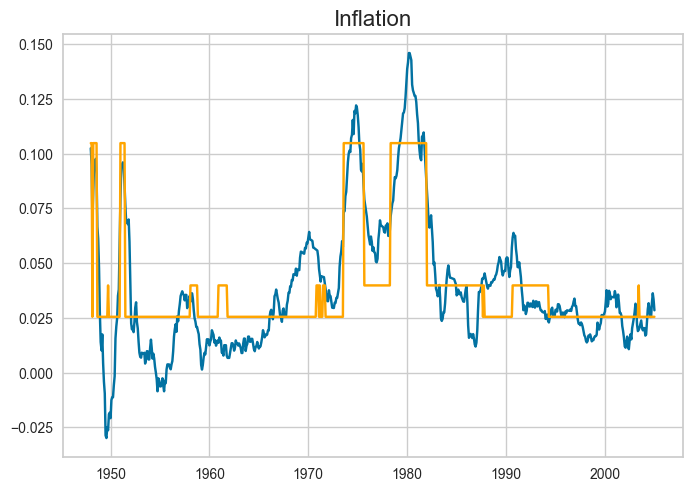

In [13]:
plt.plot(training['Inflation'])
plt.plot(training.index, centroids_Inflation, color='orange')
plt.title('Inflation', fontsize=16)

Text(0.5, 1.0, 'Unemployment Rate')

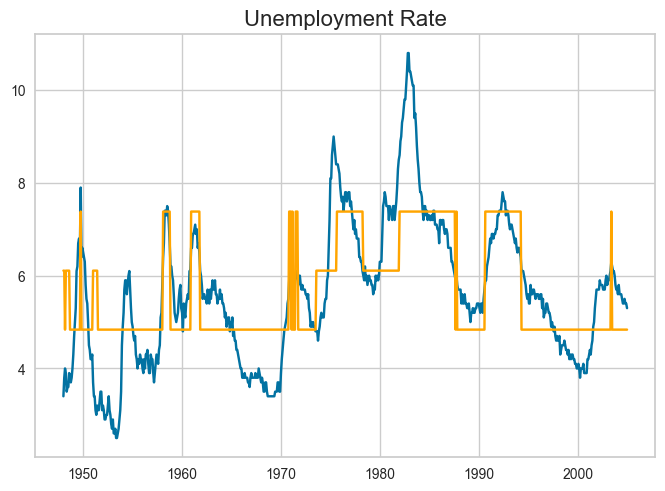

In [14]:
plt.plot(training['UNRATE'])
plt.plot(training.index, centroids_UNRATE, color='orange')
plt.title('Unemployment Rate', fontsize=16)

## Regime Predictions 

A regime-switching model is a probabilistic model that governs how regime transitions take place. A very simple regime-switching model is a Markov chain. Here, we assume that the next month's regime depends on the current regime. In other words, all we need to know are the **transition probabilities** $p_{i,j} = \mathbb{P}(X_{t+1}=j|X_t=i)$, where $X_t$ is the regime at day $t$. Using the time series of regimes in the training set, estimate these transition probabilities, as follows:
\begin{align*}
    p_{i,j} = \frac{\mathbb{P}(X_{t+1}=j \text{ and } X_t=i)}{\mathbb{P}(X_t=i)}\approx \frac{\text{number of transition from regime $i$ to $j$}}{\text{number of transition from regime $i$}}
\end{align*}
Next, let's check how good the regime switching model is. Calculate the transition probabilities using the test set. 

**As shown in the difference table, the difference of probabilities in training and testing are pretty low for all values, so it seems this method is doing a good job predicting regimes on an unobserved dataset.**

In [15]:
# predict regime with test set 
scaled_pred_test = kmc_scaled.predict(test)

# transition probabilities (training)
tp_train = np.zeros((best_k,best_k)) # rows are 'from', cols are 'to' 
counts_train = [list(scaled_pred_train[:-1]).count(i) for i in range(best_k)]

for i in range(1,len(scaled_pred_train)):
    prev_pred = scaled_pred_train[i-1]
    curr_pred = scaled_pred_train[i]
    tp_train[prev_pred, curr_pred] += 1

# transition probabilities (testing)
tp_test = np.zeros((best_k,best_k)) # rows are 'from', cols are 'to' 
counts_test = [list(scaled_pred_test[:-1]).count(i) for i in range(best_k)]

for i in range(1,len(scaled_pred_test)):
    prev_pred = scaled_pred_test[i-1]
    curr_pred = scaled_pred_test[i]
    tp_test[prev_pred, curr_pred] += 1

# cleanup 
for i in range(best_k):
    if counts_train[i] != 0:
        tp_train[i] /= counts_train[i]
    if counts_test[i] != 0:
        tp_test[i] /= counts_test[i]

tp_train = pd.DataFrame(tp_train, index=['From '+str(i) for i in range(best_k)], columns=['To '+str(i) for i in range(best_k)])
tp_test = pd.DataFrame(tp_test, index=['From '+str(i) for i in range(best_k)], columns=['To '+str(i) for i in range(best_k)])

In [16]:
tp_train

,To 0,To 1,To 2
From 0,0.936782,0.057471,0.005747
From 1,0.021028,0.971963,0.007009
From 2,0.024390,0.036585,0.939024


In [17]:
tp_test

,To 0,To 1,To 2
From 0,0.938272,0.061728,0.000000
From 1,0.032258,0.961290,0.006452
From 2,0.000000,0.100000,0.900000


In [18]:
difference = tp_test - tp_train 
difference

,To 0,To 1,To 2
From 0,0.00149,0.004257,-0.005747
From 1,0.01123,-0.010672,-0.000558
From 2,-0.02439,0.063415,-0.039024
